In [1]:
from itertools import product
from functools import partial
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from joblib import Parallel, delayed
import scipy

from nimare.generate import create_coordinate_dataset
from nimare.meta import ALE
from nimare.meta import KDA, MKDADensity
from nimare.meta import KDAKernel, ALEKernel, MKDAKernel
from nimare.correct import FDRCorrector, FWECorrector

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [2]:
N_DSET = 3
N_JOBS = None
N_ITERS = 100
OVERWRITE_DSETS = True
DSET_FILE = "./intermediate_data/test_dsets.pkl"
DATA_DIR = "./intermediate_data"

In [3]:
# Parameters
DATA_DIR = "/work/07723/jdk3232/lonestar/68e9fdfb-c16b-4563-a5c7-3d49e8fd3d26/analysis/01-code/intermediate_data"
DSET_FILE = "/work/07723/jdk3232/lonestar/68e9fdfb-c16b-4563-a5c7-3d49e8fd3d26/analysis/01-code/intermediate_data/test_dsets.pkl"
OVERWRITE_DSETS = True
N_DSET = 100
N_ITERS = 10000
N_JOBS = 48


In [4]:
if N_JOBS is None:
    N_JOBS = os.cpu_count()

In [5]:
def create_dsets(n_dsets, **kwargs):
    partial_ccd = partial(create_coordinate_dataset, **kwargs)
    # just return the dset output since there are no signal foci
    return [dset for foci, dset in Parallel(n_jobs=N_JOBS)(delayed(partial_ccd)(**{'seed': seed}) for seed in range(n_dsets))]

In [6]:
with open(os.path.join(DATA_DIR, 'peaks_distribution.pkl'), 'rb') as peaks_f:
    peaks_per_exp_dist = pickle.load(peaks_f)

with open(os.path.join(DATA_DIR, 'participants_distribution.pkl'), 'rb') as parts_f:
    participants_per_exp_dist = pickle.load(parts_f)

In [7]:
peaks_per_exp_low_high = (int(peaks_per_exp_dist.ppf(0.05)), int(peaks_per_exp_dist.ppf(0.95)))
part_per_exp_low_high = (int(participants_per_exp_dist.ppf(0.05)), int(participants_per_exp_dist.ppf(0.95)))
num_of_exp_low_high = (10, 100)

In [8]:
if OVERWRITE_DSETS or not os.path.isfile(DSET_FILE):
    dset_params = product(peaks_per_exp_low_high, part_per_exp_low_high, num_of_exp_low_high)
    dset_dict = {}
    for foci, participants, studies in dset_params:
        key = f"foci-{foci}_participants-{participants}_studies-{studies}"
        dset_dict[key] = create_dsets(N_DSET, foci=0, n_noise_foci=foci, sample_size=participants, n_studies=studies)
    with open(DSET_FILE, "wb") as pkl_file:
        pickle.dump(dset_dict, pkl_file)
else:
    with open(DSET_FILE, "rb") as pkl_file:
        dset_dict = pickle.load(pkl_file)


In [9]:
# set up the meta analysis estimators
metas = [
    ('ale', ALE),
    ('mkda', MKDADensity),
    ('kda', KDA)
]

null_methods = [
    {'null_method': 'analytic'},
    {'null_method': 'empirical', 'n_cores': 1, 'n_iters': N_ITERS},
]

dset_examples = [(params, dsets[0]) for params, dsets in dset_dict.items()]
fit_dset_args = list(product(metas, dset_examples, null_methods))

def fit_dset(meta_tuple, dset_tuple, kwargs):
    res = meta_tuple[1](**kwargs).fit(dset_tuple[1])
    p_map = res.get_map("p", return_type="array")
    fpr = (p_map < 0.05).sum() / p_map.shape[0]
    return meta_tuple[0], dset_tuple[0], kwargs['null_method'], fpr, p_map


In [10]:
if not os.path.isfile(os.path.join(DATA_DIR, "analytic_empirical_comparison_results.tsv")) or OVERWRITE_DSETS:
    estimator_results = Parallel(n_jobs=N_JOBS)(delayed(fit_dset)(*args) for args in fit_dset_args)

    estimator_collector = {'meta': [], 'dset': [], 'null_method': [], "fpr": [], "p_array": []}
    for res in estimator_results:
        estimator_collector['meta'].append(res[0])
        estimator_collector['dset'].append(res[1])
        estimator_collector['null_method'].append(res[2])
        estimator_collector['fpr'].append(res[3])
        estimator_collector['p_array'].append(res[4])

    estimator_df = pd.DataFrame(estimator_collector)
    estimator_df.to_csv(os.path.join(DATA_DIR, "analytic_empirical_comparison_results.tsv"), sep='\t', index=False)
else:
    estimator_df = pd.read_csv(os.path.join(DATA_DIR, "analytic_empirical_comparison_results.tsv"), sep='\t')

estimator_df.head()

,meta,dset,null_method,fpr,p_array
0,ale,foci-2_participants-5_studies-10,analytic,0.051472,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,ale,foci-2_participants-5_studies-10,empirical,0.057123,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,ale,foci-2_participants-5_studies-100,analytic,0.054493,"[1.0, 0.7947713859760551, 0.7947713859760551, ..."
3,ale,foci-2_participants-5_studies-100,empirical,0.051713,"[1.0, 0.8546864812455953, 0.8546864812455953, ..."
4,ale,foci-2_participants-31_studies-10,analytic,0.051175,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [11]:
ale_analytic = estimator_df.query("meta == 'ale' & null_method == 'analytic'")['p_array'].values
ale_empirical = estimator_df.query("meta == 'ale' & null_method == 'empirical'")['p_array'].values
ale_correlations = np.array([np.corrcoef(analytic, empirical)[0][1] for analytic, empirical in zip(ale_analytic, ale_empirical)])
ale_correlations

array([0.99994434, 0.99861871, 0.99998895, 0.99859815, 0.99909058,
       0.99884438, 0.99852784, 0.9998375 ])

In [12]:
mkda_analytic = estimator_df.query("meta == 'mkda' & null_method == 'analytic'")['p_array'].values
mkda_empirical = estimator_df.query("meta == 'mkda' & null_method == 'empirical'")['p_array'].values
mkda_correlations = np.array([np.corrcoef(analytic, empirical)[0][1] for analytic, empirical in zip(mkda_analytic, mkda_empirical)])
mkda_correlations

array([0.99999996, 0.99999865, 0.99999996, 0.99999837, 0.99999806,
       0.99979275, 0.99999824, 0.99979265])

In [13]:
kda_analytic = estimator_df.query("meta == 'kda' & null_method == 'analytic'")['p_array'].values
kda_empirical = estimator_df.query("meta == 'kda' & null_method == 'empirical'")['p_array'].values
kda_correlations = np.array([np.corrcoef(analytic, empirical)[0][1] for analytic, empirical in zip(kda_analytic, kda_empirical)])
kda_correlations

array([0.99999995, 0.9999988 , 0.99999996, 0.9999986 , 0.99999986,
       0.99978419, 0.99999979, 0.99978429])

Text(0.5, 1.0, 'False Positive Rates for Meta Analysis Estimators')

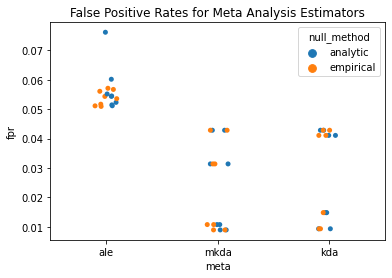

In [14]:
fig = sns.stripplot(data=estimator_df, x='meta', hue='null_method', y='fpr')
fig.set_title("False Positive Rates for Meta Analysis Estimators")

In [15]:
long_df = estimator_df.query("dset == 'foci-24_participants-5_studies-10'").explode('p_array')

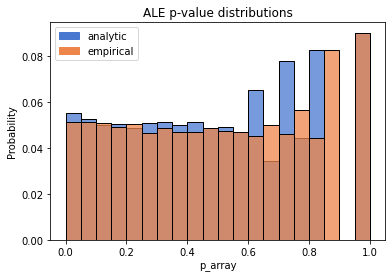

In [16]:
fig, ax = plt.subplots()
sns.histplot(
    data=long_df.query("meta == 'ale' & null_method == 'analytic'"),
    x="p_array",
    bins=20,
    ax=ax,
    color=sns.color_palette("muted")[0],
    stat="probability",
)
sns.histplot(
    data=long_df.query("meta == 'ale' and null_method == 'empirical'"),
    x="p_array",
    bins=20,
    ax=ax,
    color=sns.color_palette("muted")[1],
    stat="probability",
)
ax.legend(
    handles=[
        mpatches.Patch(color=sns.color_palette("muted")[0], label="analytic"),
        mpatches.Patch(color=sns.color_palette("muted")[1], label="empirical"),
    ]
);
ax.set_title("ALE p-value distributions");

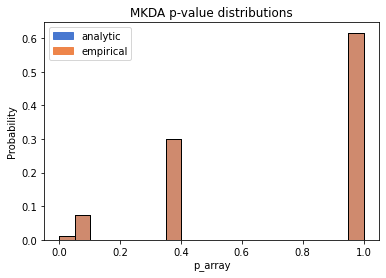

In [17]:
fig, ax = plt.subplots()
sns.histplot(
    data=long_df.query("meta == 'mkda' & null_method == 'analytic'"),
    x="p_array",
    bins=20,
    ax=ax,
    color=sns.color_palette("muted")[0],
    stat="probability",
)
sns.histplot(
    data=long_df.query("meta == 'mkda' and null_method == 'empirical'"),
    x="p_array",
    bins=20,
    ax=ax,
    color=sns.color_palette("muted")[1],
    stat="probability",
)
ax.legend(
    handles=[
        mpatches.Patch(color=sns.color_palette("muted")[0], label="analytic"),
        mpatches.Patch(color=sns.color_palette("muted")[1], label="empirical"),
    ]
);
ax.set_title("MKDA p-value distributions");

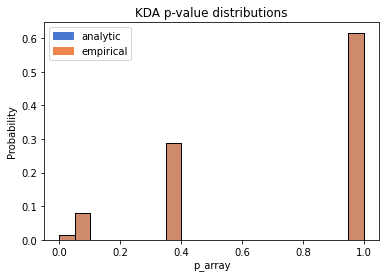

In [18]:
fig, ax = plt.subplots()
sns.histplot(
    data=long_df.query("meta == 'kda' & null_method == 'analytic'"),
    x="p_array",
    bins=20,
    ax=ax,
    color=sns.color_palette("muted")[0],
    stat="probability",
)
sns.histplot(
    data=long_df.query("meta == 'kda' and null_method == 'empirical'"),
    x="p_array",
    bins=20,
    ax=ax,
    color=sns.color_palette("muted")[1],
    stat="probability",
)
ax.legend(
    handles=[
        mpatches.Patch(color=sns.color_palette("muted")[0], label="analytic"),
        mpatches.Patch(color=sns.color_palette("muted")[1], label="empirical"),
    ]
);
ax.set_title("KDA p-value distributions");

Text(0.5, 1.0, 'ALE Empirical/Analytic Correlation')

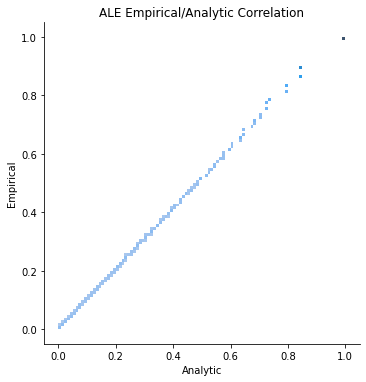

In [19]:
g = sns.displot(
    kind="hist",
    bins=100,
    x=long_df.query("meta == 'ale' & null_method == 'analytic'")['p_array'].values,
    y=long_df.query("meta == 'ale' & null_method == 'empirical'")["p_array"].values,
    rug=False,
)
g.axes[0][0].set_xlabel("Analytic");
g.axes[0][0].set_ylabel("Empirical");
g.axes[0][0].set_title("ALE Empirical/Analytic Correlation")

Text(0.5, 1.0, 'MKDA Empirical/Analytic Correlation')

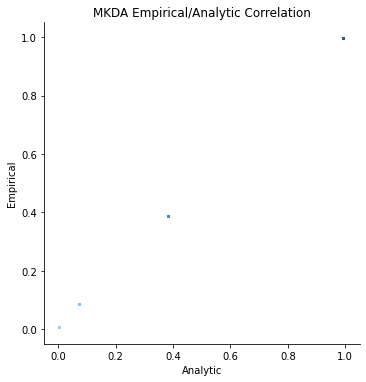

In [20]:
g = sns.displot(
    kind="hist",
    bins=100,
    x=long_df.query("meta == 'mkda' & null_method == 'analytic'")['p_array'].values,
    y=long_df.query("meta == 'mkda' & null_method == 'empirical'")["p_array"].values,
    rug=False,
)
g.axes[0][0].set_xlabel("Analytic");
g.axes[0][0].set_ylabel("Empirical");
g.axes[0][0].set_title("MKDA Empirical/Analytic Correlation")

Text(0.5, 1.0, 'KDA Empirical/Analytic Correlation')

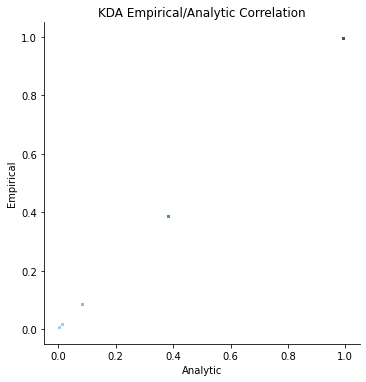

In [21]:
g = sns.displot(
    kind="hist",
    bins=100,
    x=long_df.query("meta == 'kda' & null_method == 'analytic'")['p_array'].values,
    y=long_df.query("meta == 'kda' & null_method == 'empirical'")["p_array"].values,
    rug=False,
)
g.axes[0][0].set_xlabel("Analytic");
g.axes[0][0].set_ylabel("Empirical");
g.axes[0][0].set_title("KDA Empirical/Analytic Correlation")